### Event study method ###

Below is the code that runs an event study. The method is based on [Benninga](https://mitpress.mit.edu/books/financial-modeling-fifth-edition). 

There are two variants. 

- One that uses data from Yahoo
- One that uses data from Benninga

Note that I use **estimation window** and, instead of event window, **returns window**. 

In [36]:
import pandas as pd
import numpy as np
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
import statsmodels.api as sm
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay


# The function below finds an event date on a day with a date that is on the market index.
def to_event_date(df, evdate):
    if isinstance(evdate, str):
        evdate = datetime.strptime(evdate, "%Y-%m-%d")
    elif not isinstance(evdate, datetime):
        print('check date format')
        return None
    df = df.copy()
    df.reset_index(inplace=True)
    df['drift'] = (df['Date'] - evdate).apply(lambda x: x.days)
    df['drift'] = df['drift'].where(df['drift']>=0)
    event_date = df.loc[df['drift'].argmin()]['Date']
    return event_date


# The function below finds dates that cover the estimation and the event window period, give and take 10 working dates
def find_earliest_busines_date(date, estwindow, retwindow):  # https://stackoverflow.com/questions/39067626/determine-if-a-day-is-a-business-day-in-python-pandas
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    elif not isinstance(date, datetime):
        print('check date format')
        return None
    bdays=BDay()
    return (date - (estwindow+20)*bdays, date + (retwindow+10)*bdays)


# This function runs the regression on the estimation window
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.0
    result = sm.OLS(Y, X).fit()
    output = result.params
    output['steyx'] = result.scale**.5  # https://stackoverflow.com/questions/31523921/print-std-err-value-from-statsmodels-ols-results
    output['rsq'] = result.rsquared_adj
    output['nobs'] = result.nobs
    return output


### The code below uses data from Yahoo: ###

**This function creates estimation and return windows for a single event and a single firm:**

In [37]:
def single_stock(ticker, orig_event_date, estimt_window, return_window, market):

    # ticker  = 'AIR.NZ'
    # orig_event_date = "2022-03-30"
    # estimt_window = 120
    # return_window = 3
    # market  = '^NZ50'

    longst_window = find_earliest_busines_date(orig_event_date, estimt_window, return_window)

    yahoo_mdata = yf.download(tickers=[market], start=longst_window[0], end=longst_window[1])['Adj Close'].dropna().to_frame().rename(columns = {'Adj Close': 'rm'})
    dfp = np.log(yahoo_mdata).diff().dropna()

    event_date = to_event_date(dfp, orig_event_date)

    dfp = dfp.assign(di = range(0, len(dfp)))
    dfp['di'] -= dfp.loc[event_date]['di']


    dfp = dfp.assign(rwindow = dfp['di'].where(dfp['di'].between(-return_window,    return_window), np.NaN),
                     awindow = lambda x: x['di'].where(x['di'].between(-estimt_window-return_window, -1-return_window), np.NaN),
                     ewindow = lambda x: x['awindow'].max()-x['awindow']
                     ).drop(['awindow', 'di'], axis = 1).dropna(subset=['rwindow', 'ewindow'], how='all')


    yahoo_idata = yf.download(tickers=[ticker], start=dfp.index.min()-timedelta(days=1), end=dfp.index.max()+timedelta(days=1))['Adj Close'].dropna().to_frame().rename(columns = {'Adj Close': 'ri'})
    dfi = np.log(yahoo_idata).diff().dropna()

    dfp = dfp.join(dfi)
    dfp['ri'].fillna(0, inplace=True)

    dfe = dfp.dropna(subset='ewindow').set_index('ewindow').drop('rwindow', axis=1)
    dfe['ticker'] = ticker
    dfe['date'] = orig_event_date
    dfe.set_index(['ticker', 'date'], append=True, inplace=True)


    dfr = dfp.dropna(subset='rwindow').set_index('rwindow').drop('ewindow', axis=1)
    dfr['ticker'] = ticker
    dfr['date'] = orig_event_date
    dfr.set_index(['ticker', 'date'], append=True, inplace=True)

    return dfe, dfr, dfp


dfe, dfr, dfp = single_stock('AIR.NZ',  "2022-03-30", 120, 3, '^NZ50')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
dfe.head()

,,,rm,ri
ewindow,ticker,date,,
119.0,AIR.NZ,2022-03-30,0.011818,0.003072
118.0,AIR.NZ,2022-03-30,0.000255,0.009160
117.0,AIR.NZ,2022-03-30,0.004367,0.026988
116.0,AIR.NZ,2022-03-30,-0.010346,0.002954
115.0,AIR.NZ,2022-03-30,-0.002545,0.011730


In [4]:
dfe.tail()

,,,rm,ri
ewindow,ticker,date,,
4.0,AIR.NZ,2022-03-30,0.012045,-0.007018
3.0,AIR.NZ,2022-03-30,0.000156,0.010508
2.0,AIR.NZ,2022-03-30,0.002210,-0.014035
1.0,AIR.NZ,2022-03-30,-0.011843,0.000000
0.0,AIR.NZ,2022-03-30,-0.003604,-0.021429


In [5]:
dfr

,,,rm,ri
rwindow,ticker,date,,
-3.0,AIR.NZ,2022-03-30,0.003106,0.003604
-2.0,AIR.NZ,2022-03-30,-0.012125,-0.493569
-1.0,AIR.NZ,2022-03-30,0.000835,0.010772
0.0,AIR.NZ,2022-03-30,0.014916,-0.018018
1.0,AIR.NZ,2022-03-30,0.000947,-0.063811
2.0,AIR.NZ,2022-03-30,-0.001722,-0.019570
3.0,AIR.NZ,2022-03-30,-0.003002,0.155072


---

### Running the event study for multiple stocks ###

---
**Create a data frame with firms, their associated markets and events:**

In [38]:
tickers = ['AIR.NZ', 'AIR.NZ', 'WHS.NZ', "ANZ.NZ", 'BGP.NZ', 'FPH.NZ', 'RYM.NZ', 'AIA.NZ', 'THL.NZ']
markets = ['^NZ50']*9
edates =  ["2022-02-22","2022-03-30", "2020-03-30", "2019-02-28", "2020-10-08", "2021-05-31", "2021-02-05","2018-10-25","2019-05-05"]

df_evt = pd.DataFrame(list(zip(tickers, markets, edates)), columns=['tickers', 'markets', 'edates'])
df_evt

,tickers,markets,edates
0,AIR.NZ,^NZ50,2022-02-22
1,AIR.NZ,^NZ50,2022-03-30
2,WHS.NZ,^NZ50,2020-03-30
3,ANZ.NZ,^NZ50,2019-02-28
4,BGP.NZ,^NZ50,2020-10-08
5,FPH.NZ,^NZ50,2021-05-31
6,RYM.NZ,^NZ50,2021-02-05
7,AIA.NZ,^NZ50,2018-10-25
8,THL.NZ,^NZ50,2019-05-05


**This function wraps the single_stock function. It needs the data frame with events (df_evt):**

In [39]:
def multi_stock(df_evt, estimt_window, return_window, benninga = False): #(ticker, orig_event_date):
    #ticker  = 'AIR.NZ'
    #orig_event_date = "2022-03-30"
    #estimt_window = 120
    #return_window = 3
    #market  = '^NZ50'

    dfe_list = []
    dfr_list = []
    dfp_list = []

    for index, row in df_evt.iterrows():
        print(row['tickers'], row['edates'])

        ticker          = row['tickers']
        market          = row['markets']
        orig_event_date = row['edates']

        if benninga:  # See below
            dfe, dfr, dfp = single_stock_benninga(df, ticker,  orig_event_date, estimt_window, return_window, market)
        else:
            dfe, dfr, dfp = single_stock(ticker,  orig_event_date, estimt_window, return_window, market)

        dfe_list.append(dfe)
        dfr_list.append(dfr)
        dfp_list.append(dfp)

    dfe = pd.concat(dfe_list).reset_index(level='ewindow').set_index('ewindow', append=True)
    dfr = pd.concat(dfr_list).reset_index(level='rwindow').set_index('rwindow', append=True)
    
    # Run the regression to estimate the expected returns
    dfb = dfe.groupby(['ticker', 'date']).apply(regress, 'ri', ['rm']).rename(columns = {'rm': 'beta_1', 'intercept': 'beta_0'}) # firms x  2    [rm, intercept]
    dfr = dfr.join(dfb)
    
    # Create a table with parameters and results, returns
    dfr = dfr.assign(est_ret   = lambda x: x['rm'].mul(x['beta_1']).add(x['beta_0']),
                     abn_ret   = lambda x: x['ri']-x['est_ret'],
                     tstat     = lambda x: x['steyx'].rdiv(x['abn_ret']),
                     abn_ret_1 = lambda x: x['abn_ret']+1,
                     car       = lambda x: x.groupby(['ticker', 'date'])['abn_ret_1'].transform('cumprod')-1
             )

    dfr.car.unstack().T.plot(figsize=(6,6))

    dfc = dfr.groupby(['ticker', 'date'])['abn_ret_1'].prod()-1

    return dfe, dfr.drop(['abn_ret_1'], axis = 1), dfb, dfc.to_frame().rename(columns = {'abn_ret_1': 'car'}), dfp_list

AIR.NZ 2022-02-22
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AIR.NZ 2022-03-30
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
WHS.NZ 2020-03-30
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ANZ.NZ 2019-02-28
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BGP.NZ 2020-10-08
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
FPH.NZ 2021-05-31
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
RYM.NZ 2021-02-05
[*********************100%********************

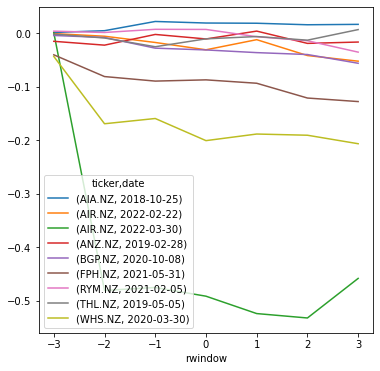

In [40]:
dfe, dfr, dfb, dfc, dfp = multi_stock(df_evt, 120, 3)

---

#### Showing the results ####

---

In [41]:
dfr

rm        ri    beta_1    beta_0     steyx  \
ticker date       rwindow                                                     
AIA.NZ 2018-10-25 -3.0    -0.012232 -0.012941  1.239275  0.000379  0.008555   
                  -2.0    -0.014773 -0.014578  1.239275  0.000379  0.008555   
                  -1.0    -0.003574  0.013129  1.239275  0.000379  0.008555   
                   0.0    -0.008601 -0.013129  1.239275  0.000379  0.008555   
                   1.0     0.000020  0.000000  1.239275  0.000379  0.008555   
...                             ...       ...       ...       ...       ...   
WHS.NZ 2020-03-30 -1.0    -0.007894 -0.005141  2.419504  0.002126  0.027560   
                   0.0     0.010871 -0.020834  2.419504  0.002126  0.027560   
                   1.0     0.013934  0.051293  2.419504  0.002126  0.027560   
                   2.0     0.013115  0.031091  2.419504  0.002126  0.027560   
                   3.0    -0.005609 -0.031091  2.419504  0.002126  0.027560   

                                rsq   nobs   est_ret   abn_ret     tstat  \
ticker date       rwindow                                                  
AIA.NZ 2018-10-25 -3.0     0.481602  120.0 -0.014780  0.001839  0.215018   
                  -2.0     0.481602  120.0 -0.017929  0.003352  0.391773   
                  -1.0     0.481602  120.0 -0.004050  0.017179  2.008139   
                   0.0     0.481602  120.0 -0.010280 -0.002850 -0.333097   
                   1.0     0.481602  120.0  0.000403 -0.000403 -0.047148   
...                             ...    ...       ...       ...       ...   
WHS.NZ 2020-03-30 -1.0     0.626360  120.0 -0.016974  0.011832  0.429324   
                   0.0     0.626360  120.0  0.028429 -0.049263 -1.787494   
                   1.0     0.626360  120.0  0.035839  0.015454  0.560756   
                   2.0     0.626360  120.0  0.033858 -0.002767 -0.100396   
                   3.0     0.626360  120.0 -0.011445 -0.019645 -0.712829   

                                car  
ticker date       rwindow            
AIA.NZ 2018-10-25 -3.0     0.001839  
                  -2.0     0.005197  
                  -1.0     0.022466  
                   0.0     0.019552  
                   1.0     0.019141  
...                             ...  
WHS.NZ 2020-03-30 -1.0    -0.159179  
                   0.0    -0.200600  
                   1.0    -0.188246  
                   2.0    -0.190492  
                   3.0    -0.206395  

[63 rows x 11 columns]

---

#### Showing the Coefficients ####

---

In [42]:
dfb

beta_1    beta_0     steyx       rsq   nobs
ticker date                                                     
AIA.NZ 2018-10-25  1.239275  0.000379  0.008555  0.481602  120.0
AIR.NZ 2022-02-22  0.926687  0.001189  0.014185  0.171701  120.0
       2022-03-30  0.917512 -0.000661  0.015832  0.169343  120.0
ANZ.NZ 2019-02-28  1.118219 -0.000567  0.013562  0.249521  120.0
BGP.NZ 2020-10-08  0.400938  0.001202  0.016406  0.053582  120.0
FPH.NZ 2021-05-31  1.503073  0.000120  0.019554  0.275067  120.0
RYM.NZ 2021-02-05  0.804952  0.000842  0.015306  0.163604  120.0
THL.NZ 2019-05-05  1.275000 -0.002745  0.024668  0.065977  120.0
WHS.NZ 2020-03-30  2.419504  0.002126  0.027560  0.626360  120.0

---

#### Showing the end-values of Cumulative Abnormal Returns ####

---

In [43]:
dfc

car
ticker date                
AIA.NZ 2018-10-25  0.017055
AIR.NZ 2022-02-22 -0.051873
       2022-03-30 -0.458494
ANZ.NZ 2019-02-28 -0.016061
BGP.NZ 2020-10-08 -0.055780
FPH.NZ 2021-05-31 -0.127475
RYM.NZ 2021-02-05 -0.034955
THL.NZ 2019-05-05  0.007257
WHS.NZ 2020-03-30 -0.206395

---

### Running the event study for data from Benninga ###

---

First get the data from the book into a data frame:

In [44]:
def get_date_benninga(fn, sn, usecol, colnames):
    df = pd.read_excel(fn, sheet_name= sn, usecols = usecol, skiprows = [0,1])
    df.columns = colnames
    df.set_index('Date', inplace=True)
    df = np.log(df).diff().dropna(how='all')
    return df

# Here your path to Benninga's file:
path = '/home/martien/Insync/cetier1@gmail.com/Google Drive/BDBA904/Benninga/S3Portfolio theory/Ch14 Event studies/'

df = get_date_benninga(path + 'FM5, Chapter 14 - Event studies.xlsm',
                       "Gillete, PG, Market-Data",
                       'A, B, D, G, J',
                       ['Date', 'nyse', 'sp500', 'gillette', 'pg']
                       )

df.tail()

,nyse,sp500,gillette,pg
Date,,,,
2007-01-26,-0.000061,-0.000716,NaN,-0.000925
2007-01-29,-0.001591,-0.000467,NaN,0.000308
2007-01-30,0.007287,0.005778,NaN,-0.004480
2007-01-31,0.005237,0.006545,NaN,0.004326
2007-02-01,0.007853,0.005891,NaN,0.007219


---

**Plotting the cumulative returns over time**

---

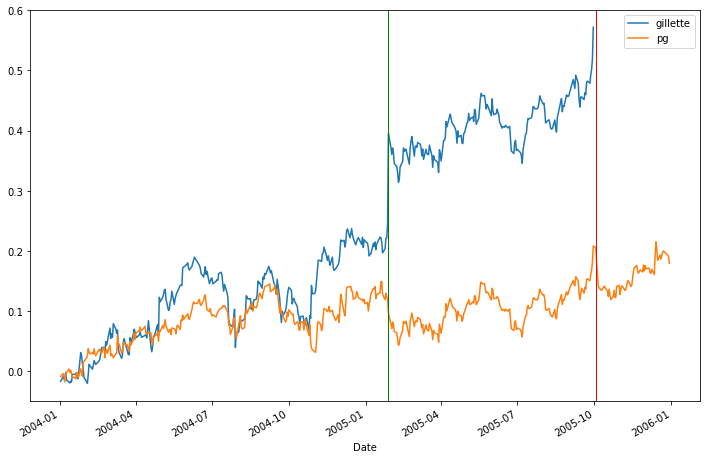

In [45]:
ax = df[['gillette', 'pg']].loc['2004': '2005'].add(1).cumprod().sub(1).plot(figsize=(12,8))

ax.axvline(x='2005-01-28', ymin=0, ymax=1,color='g', lw=1)
ax.axvline(x='2005-10-03', ymin=0, ymax=1,color='r', lw=1)

---

**Create a table of event dates by for P&G and Gillette**

Note that the event date is one day later than the one the book mentions. This to match the event window with the one of the book.

In [46]:
tickers = ['gillette',   'pg'        ]
edates =  ["2005-01-29", "2005-01-29"]
markets = ['sp500',      'sp500'     ]

df_evt = pd.DataFrame(list(zip(tickers, markets, edates)), columns=['tickers', 'markets', 'edates'])#.set_index('tickers')
df_evt


,tickers,markets,edates
0,gillette,sp500,2005-01-29
1,pg,sp500,2005-01-29


---

**This function creates estimation and return windows for a single event and a single firm:**

In [47]:
def single_stock_benninga(df, ticker, orig_event_date, estimt_window, return_window, market):

    # ticker  = 'gill'
    # market  = 'sp500'
    # estimt_window = 252
    # return_window = 3
    # orig_event_date = "2005-01-29"

    dfp = df[market].to_frame().copy().rename(columns = {market: 'rm'})
    event_date = to_event_date(dfp, orig_event_date)
    dfp = dfp.assign(di = range(0, len(dfp)))

    dfp['di'] -= dfp.loc[event_date]['di']
    
    dfp = dfp.assign(rwindow = dfp['di'].where(dfp['di'].between(-return_window, return_window), np.NaN),
                     awindow = lambda x: x['di'].where(x['di'].between(-estimt_window-return_window, -1-return_window), np.NaN),
                     ewindow = lambda x: x['awindow'].max()-x['awindow']
                     ).drop(['awindow', 'di'], axis = 1).dropna(subset=['rwindow', 'ewindow'], how='all')

    dfp = dfp.join(df[ticker].to_frame().copy().rename(columns = {ticker: 'ri'}))
    dfp['ri'].fillna(0, inplace=True)
    
    dfe = dfp.dropna(subset='ewindow').set_index('ewindow').drop('rwindow', axis=1)
    dfe['ticker'] = ticker
    dfe['date'] = orig_event_date
    dfe.set_index(['ticker', 'date'], append=True, inplace=True)
    
    
    dfr = dfp.dropna(subset='rwindow').set_index('rwindow').drop('ewindow', axis=1)
    dfr['ticker'] = ticker
    dfr['date'] = orig_event_date
    dfr.set_index(['ticker', 'date'], append=True, inplace=True)

    return dfe, dfr, dfp

dfe, dfr, dfp = single_stock_benninga(df, 'gillette',  "2005-01-29", 252, 3, 'sp500')
dfr

,,,rm,ri
rwindow,ticker,date,,
-3.0,gillette,2005-01-29,0.005792,0.000667
-2.0,gillette,2005-01-29,0.000684,0.018713
-1.0,gillette,2005-01-29,-0.003004,0.121697
0.0,gillette,2005-01-29,0.009400,-0.017201
1.0,gillette,2005-01-29,0.006955,-0.008316
2.0,gillette,2005-01-29,0.003478,0.007921
3.0,gillette,2005-01-29,-0.002654,-0.005934


---

### Running the event study for Gillette and P&G stocks ###

---

gillette 2005-01-29
pg 2005-01-29


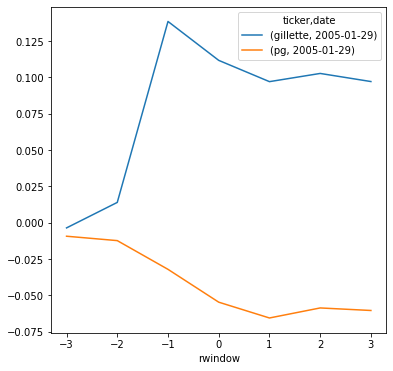

In [48]:
dfe, dfr, dfb, dfc, dfp = multi_stock(df_evt, 252, 3, benninga = True)

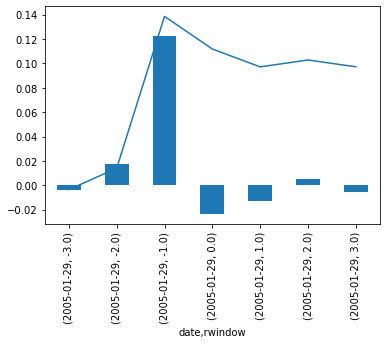

In [49]:
def abnplot(firm):
    ax = dfr.loc[firm]['car'].plot()
    ax = dfr.loc[firm]['abn_ret'].plot(kind= 'bar')
    
abnplot('gillette')

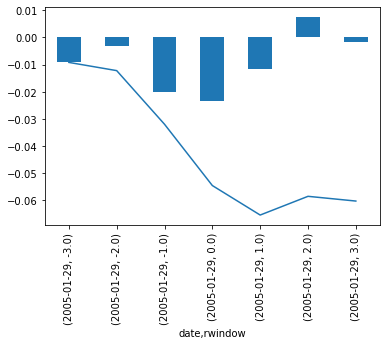

In [17]:
abnplot('pg')

---

### Safeway data ###

---

In [50]:
df = get_date_benninga(path + 'FM5, Chapter 14 - Event studies.xlsm',
                       "Safeway, Market-Data",
                       'A, B, D, F, H, J',
                       ['Date', 'sp500', 'kr', 'svu', 'swy', 'wfmi']
                       )

df.tail()

,sp500,kr,svu,swy,wfmi
Date,,,,,
2007-03-02,-0.011468,-0.007076,-0.002981,-0.021895,-0.015454
2007-03-05,-0.009452,-0.005538,-0.002445,-0.006515,0.003239
2007-03-06,0.015375,-0.002781,0.005426,0.006810,0.015192
2007-03-07,-0.002468,-0.008388,-0.009515,-0.004732,-0.020814
2007-03-08,0.007101,0.025348,0.019476,0.018505,0.002599


---

**Plotting the cumulative returns over time**

---

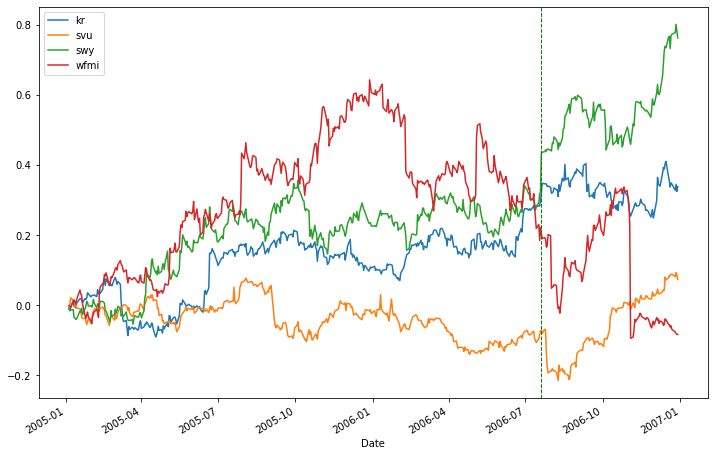

In [51]:
ax = df[['kr', 'svu', 'swy', 'wfmi']].loc['2005': '2006'].add(1).cumprod().sub(1).plot(figsize=(12,8))
ax.axvline(x='2006-07-20', ymin=0, ymax=1, color='g', lw=1, linestyle='--')

In [52]:
tickers = ['kr', 'kr', 'kr', 'kr', 'svu', 'svu', 'svu', 'svu', 'swy', 'swy', 'swy', 'swy', 'wfmi', 'wfmi', 'wfmi', 'wfmi']
edates =  ['7-Mar-06', '20-Jun-06', '12-Sep-06', '5-Dec-06', '18-Apr-06', '26-Jul-06', '10-Oct-06', '9-Jan-07', '27-Apr-06', '20-Jul-06', '12-Oct-06', '27-Feb-07', '4-May-06', '1-Aug-06', '3-Nov-06', '22-Feb-07']
surprises = ['0.03', '0.00', '0.00', '0.02', '-0.01', '-0.04', '0.08', '-0.02', '0.02', '0.06', '0.00', '0.01', '0.01', '0.01', '0.00', '-0.02']
markets = ['sp500']*16

df_evt = pd.DataFrame(list(zip(tickers, markets, edates, surprises)), columns=['tickers', 'markets', 'edates', 'surprises'])#.set_index('tickers')
df_evt['edates'] = pd.to_datetime(df_evt['edates'], format='%d-%b-%y')
df_evt['surprises'] = df_evt['surprises'].astype(float)

df_evt

,tickers,markets,edates,surprises
0,kr,sp500,2006-03-07,0.03
1,kr,sp500,2006-06-20,0.00
2,kr,sp500,2006-09-12,0.00
3,kr,sp500,2006-12-05,0.02
4,svu,sp500,2006-04-18,-0.01
5,svu,sp500,2006-07-26,-0.04
6,svu,sp500,2006-10-10,0.08
7,svu,sp500,2007-01-09,-0.02
8,swy,sp500,2006-04-27,0.02
9,swy,sp500,2006-07-20,0.06


---

### Running the event study for Supermarket stocks ###

---

kr 2006-03-07 00:00:00
kr 2006-06-20 00:00:00
kr 2006-09-12 00:00:00
kr 2006-12-05 00:00:00
svu 2006-04-18 00:00:00
svu 2006-07-26 00:00:00
svu 2006-10-10 00:00:00
svu 2007-01-09 00:00:00
swy 2006-04-27 00:00:00
swy 2006-07-20 00:00:00
swy 2006-10-12 00:00:00
swy 2007-02-27 00:00:00
wfmi 2006-05-04 00:00:00
wfmi 2006-08-01 00:00:00
wfmi 2006-11-03 00:00:00
wfmi 2007-02-22 00:00:00


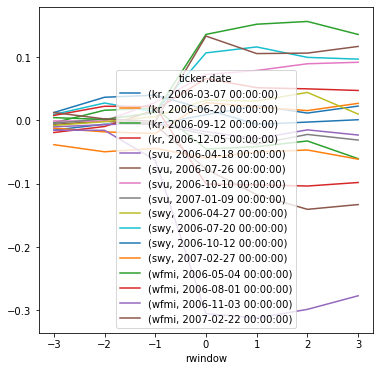

In [53]:
dfe, dfr, dfb, dfc, dfp = multi_stock(df_evt, 252, 3, benninga = 'True')

In [54]:
dfr

rm        ri    beta_1    beta_0     steyx  \
ticker date       rwindow                                                     
kr     2006-03-07 -3.0    -0.001628 -0.016228  0.666114  0.000259  0.012326   
                  -2.0    -0.001483  0.008654  0.666114  0.000259  0.012326   
                  -1.0    -0.006993 -0.004063  0.666114  0.000259  0.012326   
                   0.0    -0.001864  0.013647  0.666114  0.000259  0.012326   
                   1.0     0.002028  0.015937  0.666114  0.000259  0.012326   
...                             ...       ...       ...       ...       ...   
wfmi   2007-02-22 -1.0    -0.001405 -0.008064  1.532679 -0.002138  0.024282   
                   0.0    -0.000858  0.131259  1.532679 -0.002138  0.024282   
                   1.0    -0.003570 -0.031978  1.532679 -0.002138  0.024282   
                   2.0    -0.001255 -0.003374  1.532679 -0.002138  0.024282   
                   3.0    -0.035343 -0.046804  1.532679 -0.002138  0.024282   

                                rsq   nobs   est_ret   abn_ret     tstat  \
ticker date       rwindow                                                  
kr     2006-03-07 -3.0     0.105869  252.0 -0.000825 -0.015402 -1.249563   
                  -2.0     0.105869  252.0 -0.000729  0.009383  0.761199   
                  -1.0     0.105869  252.0 -0.004399  0.000336  0.027282   
                   0.0     0.105869  252.0 -0.000983  0.014630  1.186886   
                   1.0     0.105869  252.0  0.001610  0.014327  1.162341   
...                             ...    ...       ...       ...       ...   
wfmi   2007-02-22 -1.0     0.125133  252.0 -0.004292 -0.003772 -0.155328   
                   0.0     0.125133  252.0 -0.003453  0.134712  5.547846   
                   1.0     0.125133  252.0 -0.007610 -0.024368 -1.003555   
                   2.0     0.125133  252.0 -0.004061  0.000687  0.028309   
                   3.0     0.125133  252.0 -0.056307  0.009503  0.391362   

                                car  
ticker date       rwindow            
kr     2006-03-07 -3.0    -0.015402  
                  -2.0    -0.006164  
                  -1.0    -0.005830  
                   0.0     0.008714  
                   1.0     0.023166  
...                             ...  
wfmi   2007-02-22 -1.0    -0.001558  
                   0.0     0.132944  
                   1.0     0.105336  
                   2.0     0.106096  
                   3.0     0.116607  

[112 rows x 11 columns]

---

**Joining the surprises**

---

In [55]:
dfrs = dfr.join(df_evt.rename(columns = {'tickers': 'ticker', 'edates': 'date'}).set_index(['ticker', 'date']))
dfrs['sign'] = np.sign(dfrs['surprises'].clip(lower=0).astype(float))
dfrs

rm        ri    beta_1    beta_0     steyx  \
ticker date       rwindow                                                     
kr     2006-03-07 -3.0    -0.001628 -0.016228  0.666114  0.000259  0.012326   
                  -2.0    -0.001483  0.008654  0.666114  0.000259  0.012326   
                  -1.0    -0.006993 -0.004063  0.666114  0.000259  0.012326   
                   0.0    -0.001864  0.013647  0.666114  0.000259  0.012326   
                   1.0     0.002028  0.015937  0.666114  0.000259  0.012326   
...                             ...       ...       ...       ...       ...   
wfmi   2007-02-22 -1.0    -0.001405 -0.008064  1.532679 -0.002138  0.024282   
                   0.0    -0.000858  0.131259  1.532679 -0.002138  0.024282   
                   1.0    -0.003570 -0.031978  1.532679 -0.002138  0.024282   
                   2.0    -0.001255 -0.003374  1.532679 -0.002138  0.024282   
                   3.0    -0.035343 -0.046804  1.532679 -0.002138  0.024282   

                                rsq   nobs   est_ret   abn_ret     tstat  \
ticker date       rwindow                                                  
kr     2006-03-07 -3.0     0.105869  252.0 -0.000825 -0.015402 -1.249563   
                  -2.0     0.105869  252.0 -0.000729  0.009383  0.761199   
                  -1.0     0.105869  252.0 -0.004399  0.000336  0.027282   
                   0.0     0.105869  252.0 -0.000983  0.014630  1.186886   
                   1.0     0.105869  252.0  0.001610  0.014327  1.162341   
...                             ...    ...       ...       ...       ...   
wfmi   2007-02-22 -1.0     0.125133  252.0 -0.004292 -0.003772 -0.155328   
                   0.0     0.125133  252.0 -0.003453  0.134712  5.547846   
                   1.0     0.125133  252.0 -0.007610 -0.024368 -1.003555   
                   2.0     0.125133  252.0 -0.004061  0.000687  0.028309   
                   3.0     0.125133  252.0 -0.056307  0.009503  0.391362   

                                car markets  surprises  sign  
ticker date       rwindow                                     
kr     2006-03-07 -3.0    -0.015402   sp500       0.03   1.0  
                  -2.0    -0.006164   sp500       0.03   1.0  
                  -1.0    -0.005830   sp500       0.03   1.0  
                   0.0     0.008714   sp500       0.03   1.0  
                   1.0     0.023166   sp500       0.03   1.0  
...                             ...     ...        ...   ...  
wfmi   2007-02-22 -1.0    -0.001558   sp500      -0.02   0.0  
                   0.0     0.132944   sp500      -0.02   0.0  
                   1.0     0.105336   sp500      -0.02   0.0  
                   2.0     0.106096   sp500      -0.02   0.0  
                   3.0     0.116607   sp500      -0.02   0.0  

[112 rows x 14 columns]

---

**Showing only the day-0 abnormal returns:**

---

In [56]:
dfr_null = dfrs.loc[:,:,0]

In [57]:
dfr_null

rm        ri    beta_1    beta_0     steyx       rsq  \
ticker date                                                                     
kr     2006-03-07 -0.001864  0.013647  0.666114  0.000259  0.012326  0.105869   
       2006-06-20 -0.000008  0.050516  0.629266  0.000621  0.011641  0.101942   
       2006-09-12  0.010304 -0.056692  0.562392  0.000539  0.010822  0.106975   
       2006-12-05  0.003995  0.050777  0.424662  0.000367  0.011665  0.046975   
svu    2006-04-18  0.016933 -0.002790  0.694608 -0.000728  0.012330  0.110897   
       2006-07-26 -0.000378 -0.070874  0.543596 -0.000432  0.012404  0.077235   
       2006-10-10  0.002041  0.043631  0.626074 -0.000376  0.012767  0.095375   
       2007-01-09 -0.000517 -0.016993  0.524136  0.000229  0.013045  0.056653   
swy    2006-04-27  0.003296  0.028823  0.994554  0.000116  0.013113  0.173278   
       2006-07-20 -0.008514  0.083944  0.953007  0.000097  0.011743  0.223855   
       2006-10-12  0.009496 -0.014349  0.755419  0.000093  0.013331  0.122007   
       2007-02-27 -0.035343 -0.039503  0.716423  0.001515  0.013177  0.094624   
wfmi   2006-05-04  0.003152  0.124953  0.843977  0.000560  0.017519  0.073485   
       2006-08-01 -0.004506 -0.125093  1.146659 -0.000280  0.018111  0.154928   
       2006-11-03 -0.002226 -0.262131  1.329740 -0.000879  0.019384  0.155258   
       2007-02-22 -0.000858  0.131259  1.532679 -0.002138  0.024282  0.125133   

                    nobs   est_ret   abn_ret      tstat       car markets  \
ticker date                                                                 
kr     2006-03-07  252.0 -0.000983  0.014630   1.186886  0.008714   sp500   
       2006-06-20  252.0  0.000616  0.049900   4.286503  0.028087   sp500   
       2006-09-12  252.0  0.006334 -0.063026  -5.823822 -0.045306   sp500   
       2006-12-05  252.0  0.002063  0.048713   4.176123  0.065925   sp500   
svu    2006-04-18  252.0  0.011033 -0.013824  -1.121139 -0.017906   sp500   
       2006-07-26  252.0 -0.000638 -0.070237  -5.662285 -0.076982   sp500   
       2006-10-10  252.0  0.000902  0.042728   3.346762  0.072202   sp500   
       2007-01-09  252.0 -0.000042 -0.016951  -1.299460 -0.022361   sp500   
swy    2006-04-27  252.0  0.003394  0.025428   1.939140  0.031693   sp500   
       2006-07-20  252.0 -0.008016  0.091961   7.830991  0.106423   sp500   
       2006-10-12  252.0  0.007266 -0.021615  -1.621436  0.017247   sp500   
       2007-02-27  252.0 -0.023805 -0.015698  -1.191323 -0.059280   sp500   
wfmi   2006-05-04  252.0  0.003220  0.121733   6.948691  0.135578   sp500   
       2006-08-01  252.0 -0.005447 -0.119646  -6.606310 -0.100531   sp500   
       2006-11-03  252.0 -0.003839 -0.258291 -13.325266 -0.304891   sp500   
       2007-02-22  252.0 -0.003453  0.134712   5.547846  0.132944   sp500   

                   surprises  sign  
ticker date                         
kr     2006-03-07       0.03   1.0  
       2006-06-20       0.00   0.0  
       2006-09-12       0.00   0.0  
       2006-12-05       0.02   1.0  
svu    2006-04-18      -0.01   0.0  
       2006-07-26      -0.04   0.0  
       2006-10-10       0.08   1.0  
       2007-01-09      -0.02   0.0  
swy    2006-04-27       0.02   1.0  
       2006-07-20       0.06   1.0  
       2006-10-12       0.00   0.0  
       2007-02-27       0.01   1.0  
wfmi   2006-05-04       0.01   1.0  
       2006-08-01       0.01   1.0  
       2006-11-03       0.00   0.0  
       2007-02-22      -0.02   0.0

---

**Calculating the cross-sectional errors**

---

In [26]:
def xserrors(df):
    return np.sqrt((df.steyx @ df.steyx)/(len(df)**2))

cross_errors = dfr_null.groupby(['sign']).apply(xserrors)
cross_errors

sign
0.0    0.005408
1.0    0.004952
dtype: float64

---

**Calculating the returns and t-values per group, based on sign of earnings surprise**

---

In [58]:
dfrs_pos = pd.pivot_table(dfrs.loc[dfrs['surprises']>0,  'abn_ret'].reset_index(), values='abn_ret', index=['ticker', 'date'], columns=['rwindow'])#.sum().plot(kind='bar')
lyst = list(dfrs_pos)
dfrs_pos['sign'] = 1
#dfrs_pos['xserrors'] = cross_errors.loc[1]

dfrs_neg = pd.pivot_table(dfrs.loc[dfrs['surprises']<=0, 'abn_ret'].reset_index(), values='abn_ret', index=['ticker', 'date'], columns=['rwindow'])#.sum()#.plot(kind='bar', color='r')
dfrs_neg['sign'] = 0
#dfrs_neg['xserrors'] = cross_errors.loc[0]

dfrs_z = pd.concat([dfrs_pos, dfrs_neg]).sort_index()

dfrs_z

rwindow                -3.0      -2.0      -1.0       0.0       1.0       2.0  \
ticker date                                                                     
kr     2006-03-07 -0.015402  0.009383  0.000336  0.014630  0.014327 -0.011431   
       2006-06-20 -0.012312 -0.005985 -0.002600  0.049900 -0.006721 -0.005705   
       2006-09-12 -0.003816  0.019799  0.002958 -0.063026  0.003900  0.009402   
       2006-12-05 -0.019226  0.009658  0.026424  0.048713 -0.013560 -0.001711   
svu    2006-04-18 -0.010190  0.003329  0.002774 -0.013824 -0.011212  0.014286   
       2006-07-26 -0.006289  0.005007 -0.005949 -0.070237 -0.043586 -0.026306   
       2006-10-10 -0.001023 -0.000287  0.029614  0.042728  0.006026  0.009830   
       2007-01-09 -0.004507  0.006884 -0.007830 -0.016951 -0.015630  0.015971   
swy    2006-04-27 -0.008080  0.005989  0.008267  0.025428 -0.001192  0.013171   
       2006-07-20  0.009261  0.017893 -0.013701  0.091961  0.008467 -0.014735   
       2006-10-12  0.012284  0.023822  0.003204 -0.021615 -0.023204  0.003617   
       2007-02-27 -0.038391 -0.011679  0.005623 -0.015698  0.009980  0.003238   
wfmi   2006-05-04  0.004252 -0.002780  0.010867  0.121733  0.014156  0.003773   
       2006-08-01  0.007687  0.014397 -0.000470 -0.119646 -0.001405 -0.002087   
       2006-11-03 -0.015662 -0.000060 -0.047859 -0.258291 -0.010009  0.019739   
       2007-02-22  0.012344 -0.009999 -0.003772  0.134712 -0.024368  0.000687   

rwindow                 3.0  sign  
ticker date                        
kr     2006-03-07  0.010860     1  
       2006-06-20  0.011296     0  
       2006-09-12 -0.028873     0  
       2006-12-05 -0.002439     1  
svu    2006-04-18 -0.008264     0  
       2006-07-26  0.008755     0  
       2006-10-10  0.002147     1  
       2007-01-09 -0.009038     0  
swy    2006-04-27 -0.032737     1  
       2006-07-20 -0.002524     1  
       2006-10-12  0.003725     0  
       2007-02-27 -0.015194     1  
wfmi   2006-05-04 -0.017739     1  
       2006-08-01  0.006216     1  
       2006-11-03  0.030568     0  
       2007-02-22  0.009503     0

---

**Calculating the final results per group**

---

<AxesSubplot:xlabel='rwindow'>

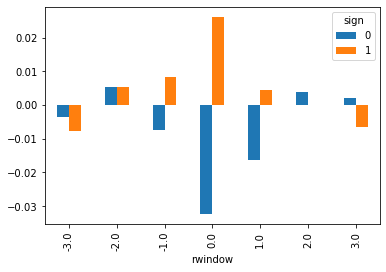

In [59]:
# Abnormal returns
df_aar = dfrs_z.groupby(['sign'])[lyst].mean().T
df_aar.plot(kind='bar')

<AxesSubplot:xlabel='rwindow'>

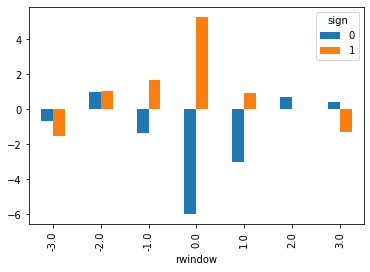

In [60]:
# t-statistics
df_tvl = df_aar.div(cross_errors)
df_tvl.plot(kind='bar')

<AxesSubplot:xlabel='rwindow'>

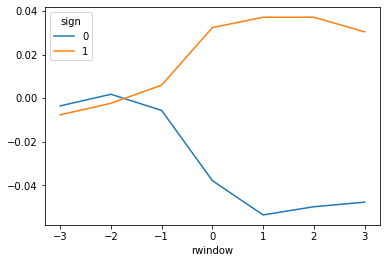

In [62]:
# CARs
df_car = df_aar.add(1).cumprod().sub(1)
df_car.plot()

In [63]:
df_aar

sign,0,1
rwindow,,
-3.0,-0.003519,-0.007615
-2.0,0.005350,0.005322
-1.0,-0.007384,0.008370
0.0,-0.032417,0.026231
1.0,-0.016354,0.004600
2.0,0.003961,0.000006
3.0,0.002209,-0.006426
